In [3]:
%%capture output
!pip install pandas
!pip install matplotlib
!pip install opencv-python
!pip install scikit-learn scikit-image

# Captured output on this cell to maintain notebook tidiness :)

# Recognizing Traffic Signs

### The Goal ###

The goal of this notebook is to process traffic sign images and classify them using machine learning. We will explore various techniques for feature extraction, including **Histogram of Oriented Gradients (HOG)** and **color-based thresholding**, and evaluate different classifiers such as **Support Vector Machines (SVM)** and **Random Forests**. 

By the end of this notebook, we aim to build a model that can accurately recognize traffic signs, which is crucial for applications like **autonomous driving and traffic monitoring**.

### The Data 
The data for this project is a series of images of traffic signs, captured under different real life conditions such as:
- Normal lighting 
- Poor lighting
- Obstructions 
- Signs that are at varying distances from the camera. 

To ensure consistency, the images have been pre-processed, in that they are 
- Cropped to focus ont he traffic sign.
- Scaled to a uniform size for model training.
- Loaded into three python objects for easier manipulation in training, validation and testing. 

Each image has a corresponding sign label indicating the type of sign it represents. The labels are provided in a CSV file which serves as the ground truth for training and evaluating. 

The original unprocessed dataset can be found at <a href="https://www.kaggle.com/datasets/imadmoussa/traffic-signs/code" target="_blank">Kaggle</a>. where it was collected for traffic sign recognition research.

In [4]:
# Unzip
import zipfile
data = "data/"
with zipfile.ZipFile(data+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(data)
with zipfile.ZipFile(data+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(data)
with zipfile.ZipFile(data+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(data)

In [5]:
# Load sign names

import pandas as pd
df = pd.read_csv("./data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [6]:
# Load images
import pickle
#load pickle for training data
signimages = pickle.load( open( data+"train.p", "rb" ) )

#load pickle for validation
signimages_validation = pickle.load( open( data+"valid.p", "rb" ) )

#load pickle for testing
signimages_test = pickle.load( open( data+"test.p", "rb" ) )

### Exploring The Data

To get an idea of what the pictures of traffic signs in the dataset look like, we can preview any image in the training data, as the pickle for the training data is already loaded above. Exploring the structure of the data provided tells us that the pictures of traffic signs correspond to the dictionary key "features". 

Previewing an image at random can therefore be done by calling on a picture by its positon inside the "features" key. Then we look at the corresponding sign name, and the indexing within the image that carries matrixes for the RGB values that correspond with each pixel. Exploring the indexing is not a neccessary step, but it is preferred as understanding the data in detail is useful to determine which features can be easily extracted from the pictures. 

In [7]:
print(signimages.keys())

dict_keys(['coords', 'labels', 'features', 'sizes'])


The image shows a General caution sign.


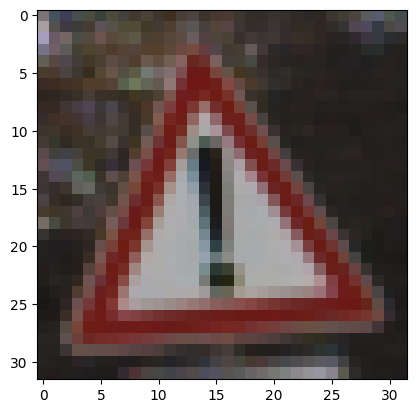

In [ ]:
# Preview image
import matplotlib.pyplot as plt
import numpy as np
import cv2

inx = 20500

#inserting a pixel in this image to check which way the pixels are labelled
#signimages['features'][inx][5][20] = [0,255,0]

plt.imshow(signimages['features'][inx])
print(f"The image shows a {signnames[signimages['labels'][inx]]} sign.")


In [ ]:
# Printing rgb values for a pixel in the above picture. This is to help me identify the indexing in the image object.
print(signimages['features'][inx][27][5])

[110  27  24]


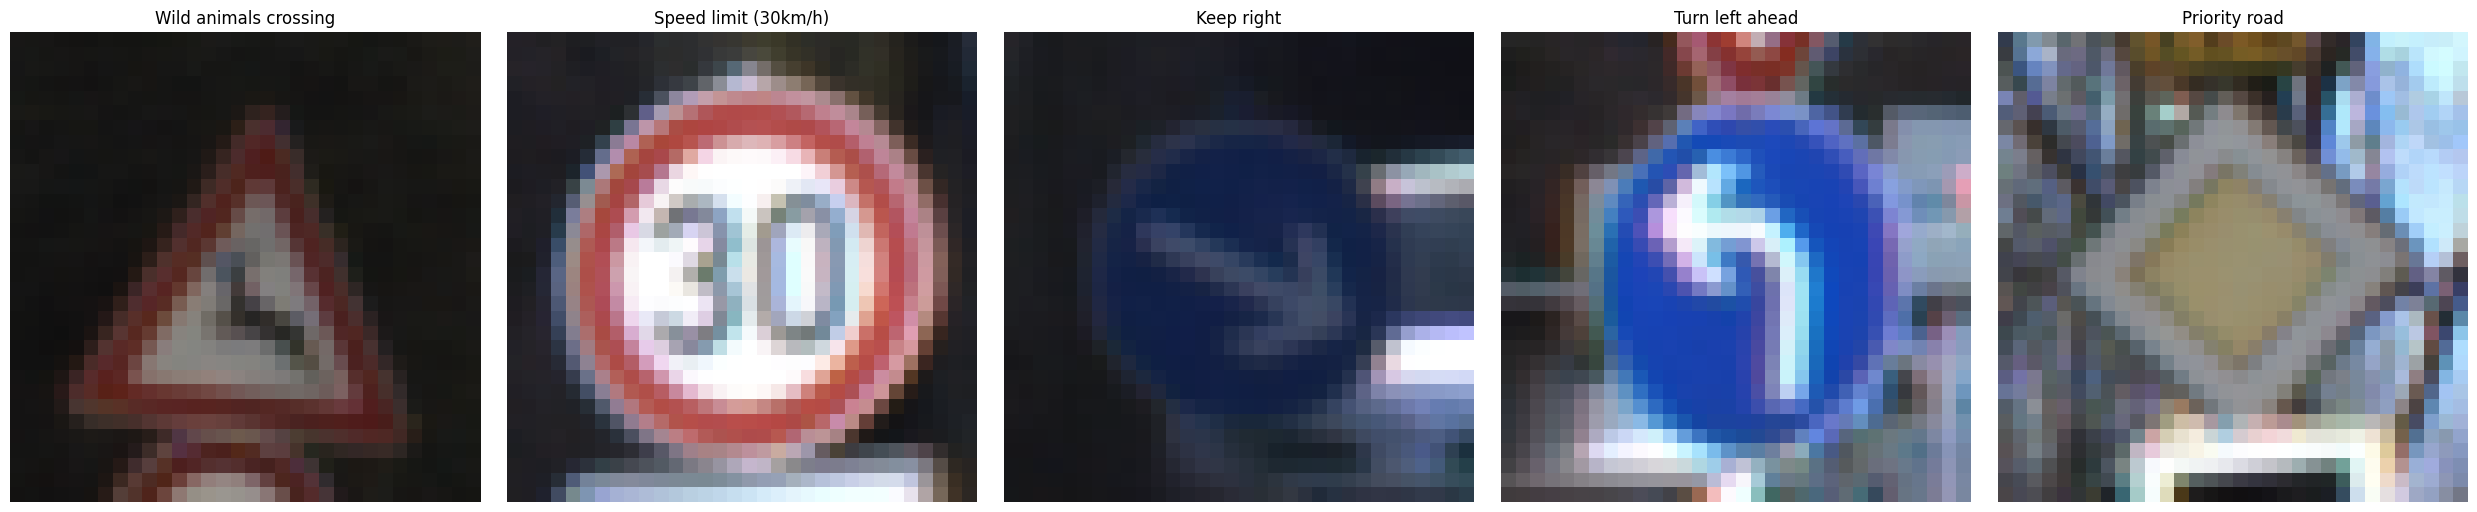

In [59]:
# Displaying images in a moisaic to understand data better

image_indices = [790, 3678, 14565, 20123, 28463 ]

# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, len(image_indices), figsize=(25, 5))

# Loop through indices to plot images and labels
for i, ax in enumerate(axes):
    ax.imshow(signimages['features'][image_indices[i]])  # Display image
    ax.set_title(signnames[signimages['labels'][image_indices[i]]])  # Set label as title
    ax.axis("off")  # Hide axes for cleaner display

# Show the plot
plt.tight_layout()
plt.show()

From the above diagram we get an idea of what some of the images we are classifying look like. It is clear that some of the "features" that make these road signs distinct to us is the color scheme, the shape of the sign itself, and upon close inspection, the symbols inside the signs. Some signs like the "Keep right" and the "Turn left ahead" sign as seen above have similar shapes and colors, which might make it harder to classify. Another factor to consider is the conditions under which each picture has been captured. Below we can take a look at five images that display the same sign to get an idea of how varied the picture clarity and lighting conditions are. This helps also determine if those conditions significantly affect the identifiability of the signs based on color and shape that is visible. 

In [ ]:
# Displaying images of the same road sign in a moisaic 

image_indices = [790, 3678, 14565, 20123, 28463 ]

# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, len(image_indices), figsize=(25, 5))

# Loop through indices to plot images and labels
for i, ax in enumerate(axes):
    ax.imshow(signimages['features'][image_indices[i]])  # Display image
    ax.set_title(signnames[signimages['labels'][image_indices[i]]])  # Set label as title
    ax.axis("off")  # Hide axes for cleaner display

# Show the plot
plt.tight_layout()
plt.show()

### Feature Extraction

Based on the above exploration of the data, there are a few possible features to be extracted. 

1. Shape: A lot of the signs have distinct shapes like triangles and circles. 
2. Color: Most signs have distinct solid colors, often blue, white, black, and red.

Since the goal here is to build an accurate classifier model with the best features, we have a few choices for feature extraction. A feature descriptor that considers both shape and edge information as well as color information is a HOG (Histogram of Oriented Gradients). 

The feature data needs to be included in the dataframes for training, validation and testing data, so the best method to do so is to create a function that takes in the python object with the source data and some HOG parameters.By taking the HOG parameters as arguments they can be easily adjusted o find the amunt of data features that can give the best model.

For a Histogram of Oriented Gradients, the parameters I find important are:

1. The amount of pixels in a cell block- less pixels per cell block means more data generated- more data is not necessarily always the best approach, but the pictures in this dataset are quite small to begin with, so less pixels per cell-block is the better approach. 
2. The number of orientations- simply put, the amount of bins for the histogram that measure the direction of the gradient. 


In [ ]:
#____________________________________________________________

############# Using HOG to extract features #################
#____________________________________________________________

from skimage.feature import hog

#create a function to generate a dataframe 
def generate_dataframe(imgs, 
                       orientations = 8, 
                       pixels_per_cell = (4,4)): #orientatins and pixels per cell given a default value
    hog_data = []
    for inx in range(len(imgs["features"])):
        image = imgs ["features"][inx]
        hog_description = hog(image, 
                              orientations = orientations, 
                              pixels_per_cell= pixels_per_cell, 
                              cells_per_block = (2, 2), 
                              channel_axis= 2)  #why 2? because colors are in the third index
        label = np. array([imgs["labels"][inx]])
        hog_data.append(np.concatenate((label, hog_description)))

#convert list of rows in dataframe 
    ret_df = pd.DataFrame(hog_data)
    return ret_df.rename(columns = {0:"target"})

To make this code flexible and to make it easier to test out other parameter combinations, I write it so all the processing is done dynamically based on the input list of parameters. I use a list of parameters here so I can later determine which combinations of inputs in the feature extraction stage can give me the best trained model later. 

This code generates four different sets of training, validation and testing data sets.

In [ ]:
#HOG parameter combinations to be tested
list_of_parameters = [
    { "orientations": 8, "pixels_per_cell": (4,4) },
    { "orientations": 16, "pixels_per_cell": (4,4) },
    { "orientations": 8, "pixels_per_cell": (8,8) },
    { "orientations": 16, "pixels_per_cell": (8,8) }
]

#list comprehension to create list of dataframes for train/validation/test for HOG parameter combinations
train_dataframes = [ generate_dataframe(signimages, params["orientations"], params["pixels_per_cell"]) for params in list_of_parameters ]

validation_dataframes = [ generate_dataframe(signimages_validation, params["orientations"], params["pixels_per_cell"]) for params in list_of_parameters ]

test_dataframes = [ generate_dataframe(signimages_test, params["orientations"], params["pixels_per_cell"]) for params in list_of_parameters ]



In [ ]:
# Creating X Y split for train,validation and test dataframes.

train_xy_dataframes = [ (train_dataframe.drop(['target'], axis=1), train_dataframe['target']) for train_dataframe in train_dataframes ]

validate_xy_dataframes = [ (validate_dataframe.drop(['target'], axis=1), validate_dataframe['target']) for validate_dataframe in validation_dataframes ]

test_xy_dataframes = [ (test_dataframe.drop(['target'], axis=1), test_dataframe['target']) for test_dataframe in test_dataframes ]

### Running a Classifier 

A Support Vector Classifier is a good choice for this dataset, as it performs well in handling complex boundaries between classes of items, especially when they have similar shapes and colors but different symbols, as is usually the case in traffic signs. Below we train a few models on the datasets produced from changing different HOG parameters to determine the best accuracy level and the best accuracy retention when the models are tested on new data. 

In [ ]:
#____________________________________________________________

########### Using Support Vector Classifier ###############
#____________________________________________________________

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 

# Creating a list of models trained on the list of X and Y data we just made in the above cell

svcs = []
for train_x, train_y in train_xy_dataframes:
    svc = SVC(kernel='linear')
    svc.fit(train_x, train_y)
    svcs.append(svc)

In [ ]:
#Using the list of SVC models based on the different HOG parameters to predict the traffic sign labels on validation data
validation_accuracy_scores = []

for (validate_x, validate_y), svc in zip(validate_xy_dataframes, svcs):
    y_pred = svc.predict(validate_x)
    accuracy = accuracy_score(validate_y, y_pred)
    validation_accuracy_scores.append(accuracy)



In [ ]:

dataframe_names = [ f"HOG_{params['orientations']}_{params['pixels_per_cell']}" for params in list_of_parameters ] 

#printing SVC model prediction accuracy for each model type
for score, name in zip(validation_accuracy_scores, dataframe_names):
    print(f"SVC model on validation data with {name} has an accuracy score of {score *100:.2f}% ")

SVC model on validation data with HOG_8_(4, 4) has an accuracy score of 90.02% 
SVC model on validation data with HOG_16_(4, 4) has an accuracy score of 90.14% 
SVC model on validation data with HOG_8_(8, 8) has an accuracy score of 78.84% 
SVC model on validation data with HOG_16_(8, 8) has an accuracy score of 80.57% 


In [ ]:
#Using the list of SVC models based on the different HOG parameters to predict the traffic sign labels on test data
test_accuracy_scores = []

for (test_x, test_y), svc in zip(test_xy_dataframes, svcs):
    y_pred = svc.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    test_accuracy_scores.append(accuracy)


In [ ]:
#printing accuracy score of each model on testing data
for score, name in zip(test_accuracy_scores, dataframe_names):
    print(f"SVC model on testing data with {name} features has an accuracy score of {score *100:.2f}% ")

SVC model on testing data with HOG_8_(4, 4) features has an accuracy score of 88.51% 
SVC model on testing data with HOG_16_(4, 4) features has an accuracy score of 88.03% 
SVC model on testing data with HOG_8_(8, 8) features has an accuracy score of 78.11% 
SVC model on testing data with HOG_16_(8, 8) features has an accuracy score of 78.86% 


### Conclusion

A Linear SVC model run with more feature data extracted from image pixels produce a higher accuracy This corresponds to the Pixels-per-Cell parameter in the HOG feature extraction. A small square of Pixels-per-Cell results in more information extracted from the whole image, as more pixels are individually assessed for feature information.

Increasing the Orientation parameter in feature extraction, which corresponds to information about the direction of the gradients has less impact on the accuracy of the model. The worst model performance is from the model that recieved the least amount of features in total. 

### Best Choice: Model A
Model A (Linear SVC, HOG: 8 Orientations, Pixels per Cell 4x4) has the highest prediction accuracy and a low generalization gap compared to Model B, which has a marginally better accuracy score but a far worse generalization gap, which means it could perform better in future use as well when exposed to further unseen data.

| Model  | Test Accuracy (%) | Unseen Dataset Accuracy (%) | Generalization Gap |
|--------|-----------------|-----------------------------|---------------------|
| **A**  | 90.02          | 88.51                        | **1.51**           |
| **B**  | 90.14          | 88.03                        | **2.11**           |
| **C**  | 78.84          | 78.11                        | **0.73**           |
| **D**  | 80.57          | 78.86                        | **1.71**           |



